In [1]:
''' Import libraries '''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
''' Load data '''
df_all = pd.read_csv("/Users/bryanmcelvy/Documents/datasets/Heart_Disease_Prediction.csv").drop(["index"], axis=1)
df = df_all.drop("Heart Disease", axis=1)
df_target = df_all["Heart Disease"]

df.head(10)

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3
5,65,1,4,120,177,0,0,140,0,0.4,1,0,7
6,56,1,3,130,256,1,2,142,1,0.6,2,1,6
7,59,1,4,110,239,0,2,142,1,1.2,2,1,7
8,60,1,4,140,293,0,2,170,0,1.2,2,2,7
9,63,0,4,150,407,0,2,154,0,4.0,2,3,7


In [3]:
''' Show basic statistical data for each column '''
df.describe()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


Text(0, 0.5, 'Percentage')

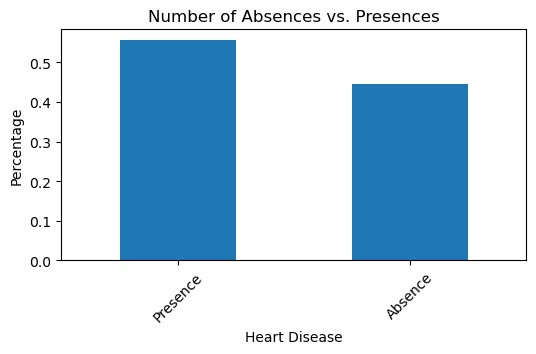

In [4]:
''' Show bar graph for target variable (heart disease) '''
ax = df_target.value_counts(normalize=True).plot(kind='bar')
fig = ax.get_figure()
fig.set_size_inches(6,3)

ax.set_title("Number of Absences vs. Presences")
ax.set_xlabel("Heart Disease"); ax.set_xticklabels(df_target.unique(), rotation=45)
ax.set_ylabel("Percentage")

**Kurtosis** – Measure of how heavy-tailed/light-tailed the data is compared to normal distribution
- Mesokurtic (kurt ~= 3): tails similar to Gaussian
- Platykurtic (kurt < 3): thinner tail, shorter distribution; low presence of extreme values
- Leptokurtic (kurt > 3): thicker tail, longer distribution; extreme values present

**Skewness** – Measure of symmetry
- Left-skewed (skew < -0.5): tail is on left of mean; majority of data on right; outliers on right
- Right-skewed/positively-skewed (skew > 0.5): tail is on right of mean; majority of data on left; outliers on left
- Symmetric (-0.5 < skew < 0.5): left and right sides are mirrors of each other

In [5]:
''' Calculate measures of spread for each non-target column '''
df_spread = pd.DataFrame(columns=["kurtosis", "skewness"], index=df.columns)
for feature in df_spread.index.values:
    df_spread.loc[feature, "kurtosis"] = df[feature].kurt()
    df_spread.loc[feature, "skewness"] = df[feature].skew()
    
df_spread

,kurtosis,skewness
Age,-0.544815,-0.163615
Sex,-1.425259,-0.765084
Chest pain type,-0.296548,-0.878767
BP,0.923097,0.722618
Cholesterol,4.895599,1.183721
FBS over 120,1.982578,1.991971
EKG results,-2.005358,-0.044703
Max HR,-0.103072,-0.527737
Exercise angina,-1.479699,0.728915
ST depression,1.759317,1.262893


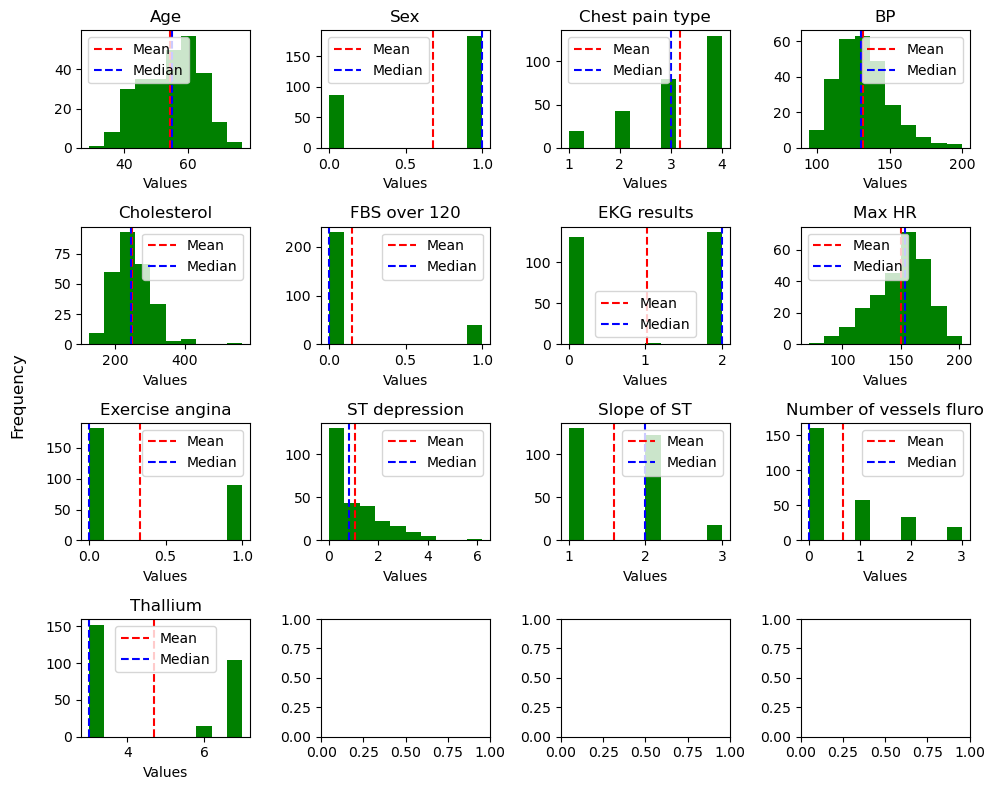

In [6]:
''' Plot histograms for each non-target variable '''
fig, axs = plt.subplots(4,4, figsize=[10,8], tight_layout=True)
fig.supylabel("Frequency", x=0.01)

for row_num, ax_row in enumerate(axs):
    for col_num, ax_col in enumerate(axs[row_num]):
        feat_idx = (4 * row_num) + col_num
        if feat_idx < len(df.columns):
            ax = axs[row_num][col_num]
            ax.hist(df.iloc[:, feat_idx], color='green')
            ax.axvline(x=df.iloc[:, feat_idx].mean(), linestyle='--', color='r', label='Mean')
            ax.axvline(x=df.iloc[:, feat_idx].median(), linestyle='--', color='b', label='Median')
            
            ax.set_title(df.columns[feat_idx])
            ax.set_xlabel("Values")
            ax.legend()
            ax.legend()

Text(0.02, 0.5, '')

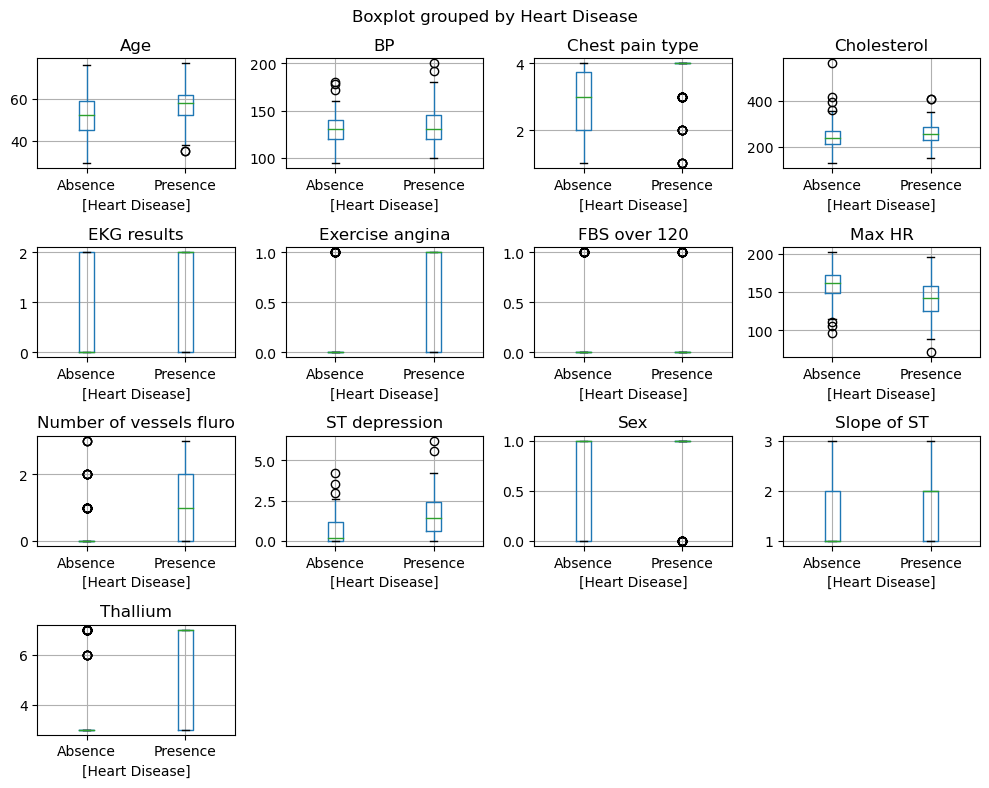

In [7]:
axs_box = df_all.boxplot(by=df_all.columns[-1], return_type='axes', sharex=False, sharey=False)
fig_box = axs_box[0].get_figure()
fig_box.set_size_inches([10, 8])
fig_box.tight_layout()
fig_box.supylabel("")

In [10]:
''' Manually encode target variable as 1 for Presence and 0 for Absence'''
target_vals = df_all.iloc[:,-1].to_numpy()
for count, val in enumerate(target_vals):
    if val == "Presence":
        target_vals[count] = 1
    elif val == "Absence":
        target_vals[count] = 0
df_all.iloc[:,-1] = target_vals
df_all.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,1
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,0
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,1
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,0
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,0


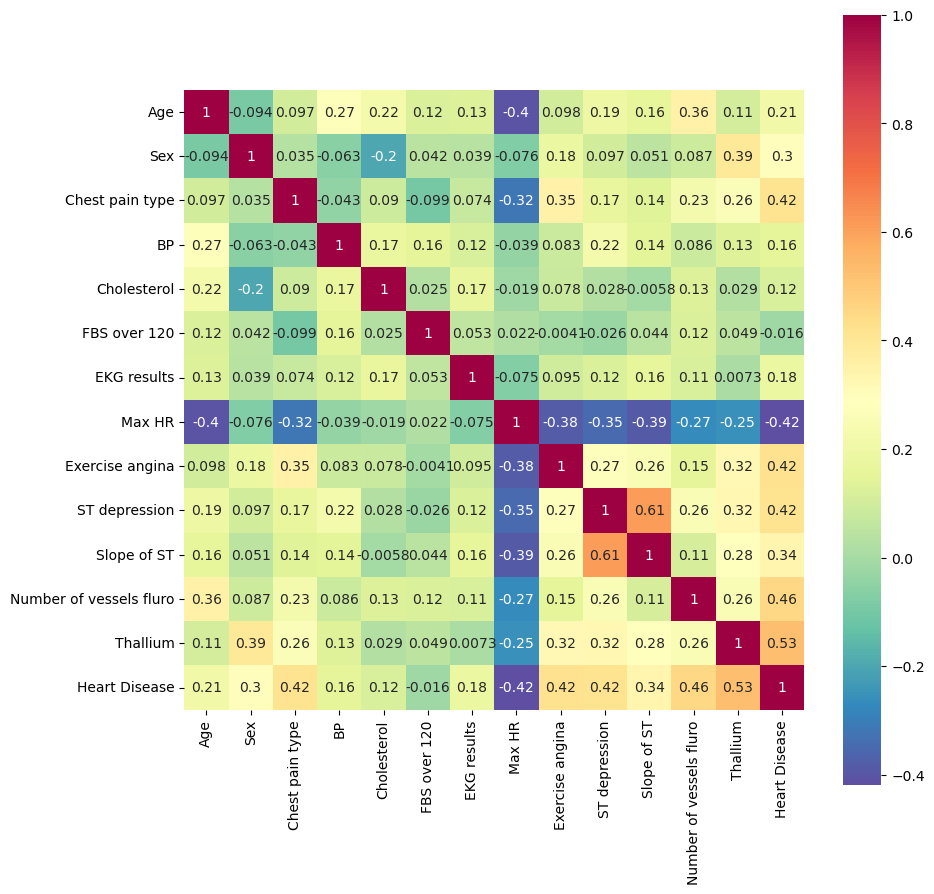

In [11]:
''' Create heatmap '''
corrmat = df_all.corr(numeric_only=False)
ax_hm = sns.heatmap(data=corrmat, annot=True, square=True,
                    xticklabels=df_all.columns, yticklabels=df_all.columns, cmap="Spectral_r")
fig_hm = ax_hm.get_figure()
fig_hm.set_size_inches([10,10])